## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.layers import Mish, MaxPool, LabelSmoothingCrossEntropy
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter, CategoryBlock

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import *
from fastai2.vision.core import *
from fastai2.vision.augment import *
from fastai2.vision.learner import unet_learner, unet_config
from fastai2.vision.models.xresnet import xresnet50, xresnet34

from fastai2.data.transforms import Normalize, parent_label
from fastai2.data.external import download_url, URLs, untar_data


from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

In [2]:
torch.cuda.set_device(6)

## Pretext Task: Image Inpainting

In [3]:
# # Default parameters
# gpu=None
# lr=1e-2
# size=128
# sqrmom=0.99
# mom=0.9
# eps=1e-6
# epochs=15
# bs=64
# mixup=0.
# opt='ranger',
# arch='xresnet50'
# sh=0.
# sa=0
# sym=0
# beta=0.
# act_fn='Mish'
# fp16=0
# pool='AvgPool',
# dump=0
# runs=1
# meta=''

In [4]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=1
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xresnet18
act_fn = Mish
pool = MaxPool

In [5]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train'))

(7750, 14669)

In [6]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
#     item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
#     batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    item_tfms = None
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    files = get_image_files(source)
    dsets = Datasets(files, tfms=[[PILImage.create, ToTensor, Resize(size)], [lambda x: x.parent.name, Categorize()]], 
                     splits=RandomSplitter(valid_pct=0.1)(files))
    
    dls = dsets.dataloaders(bs=bs, num_workers=workers, 
                             before_batch=item_tfms, after_batch=batch_tfms)
    dls.path = source
    return dls

In [7]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [8]:
size = 160
bs = 256

dbunch = get_dbunch(size, bs, sh=sh)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.c = 20
dbunch.valid.shuffle = True

In [9]:
len(dbunch.train.dataset)

23714

In [10]:
xb,yb = dbunch.one_batch()
xb.shape, yb.shape

(torch.Size([256, 3, 160, 160]), torch.Size([256]))

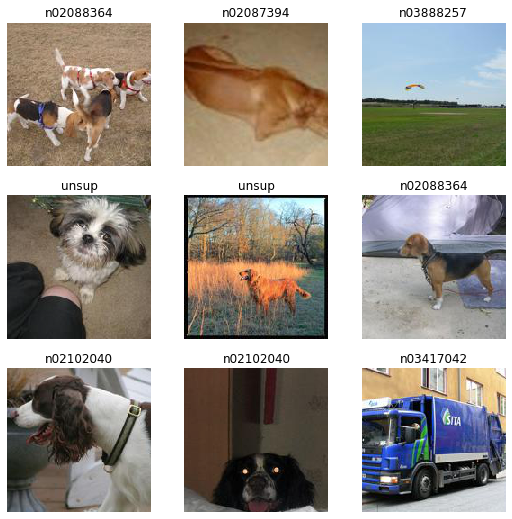

In [11]:
dbunch.show_batch()

In [12]:

from rsna_retro.self_supervised import *
from rsna_retro.contrastive_loss import *

Loading imports


In [13]:
m_part = partial(m, c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool)

In [14]:
ss_name = 'imagewang_contrast_ss1'

In [15]:
aug = get_aug_pipe(size, min_scale=0.35, mult=1)
aug2 = get_aug_pipe(size, min_scale=0.3, mult=2)
cbs = SSCallback(BatchContrastiveLoss(XentContrastiveLoss(0.05)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=False)


ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
        metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs,
                   config={'custom_head':ch})
#         metrics=[], loss_func=LabelSmoothingCrossEntropy())

In [16]:
learn.fit_flat_cos(30, 1e-2, wd=1e-2)

epoch,train_loss,valid_loss,time
0,1.515555,1.658458,00:34
1,0.979689,1.129493,00:32
2,0.784261,0.835150,00:32
3,0.689297,0.786868,00:32
4,0.613757,0.520607,00:32
5,0.587858,0.644272,00:32
6,0.575047,0.674016,00:32
7,0.509991,0.666205,00:33
8,0.514127,0.543344,00:33
9,0.464283,0.605443,00:33


In [17]:
learn.save(ss_name)

## Downstream Task: Image Classification

In [36]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    files = get_image_files(source, folders=['train','val'])
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)], 
            [lambda x: x.parent.name, Categorize()]]
#     dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(valid_name='val')(files))
    
    item_tfms = None
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, 
                             before_batch=item_tfms, after_batch=batch_tfms)
    dls.path = source
    return dls

In [37]:
dbunch = get_dbunch(size, bs, sh=sh)

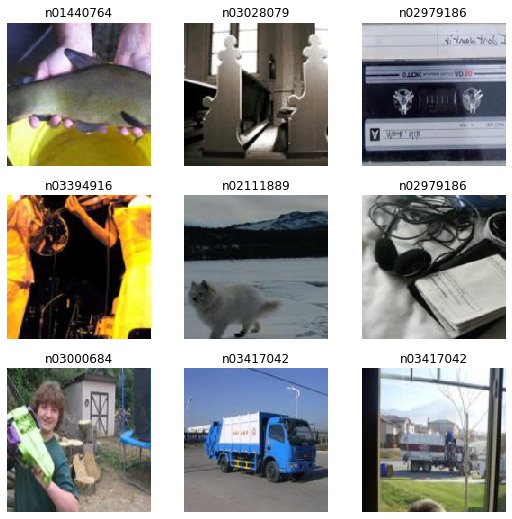

In [39]:
dbunch.show_batch()

### 5 Epochs

In [40]:
epochs = 5
runs = 5

In [41]:
for run in range(runs):
        print(f'Run: {run}')
        
#         aug = get_aug_pipe(size, min_scale=1.0, mult=1)
#         aug2 = get_aug_pipe(size, min_scale=0.3, mult=1)
#         cbs = SSCallback(BatchContrastiveLoss(XentContrastiveLoss(0.05)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=True)

        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.947737,5.242933,0.001273,0.053449,00:12
1,2.284983,4.609402,0.007890,0.114278,00:12
2,1.918409,4.213024,0.018325,0.202087,00:12
3,1.668349,3.917625,0.026724,0.288114,00:12
4,1.512675,3.852005,0.029015,0.321201,00:12


Run: 1


KeyboardInterrupt: 

- Run 1: 0.403156
- Run 2: 0.404429
- Run 3: 0.416645
- Run 4: 0.407228
- Run 5: 0.412064

Average: **40.87%**

### 20 Epochs

In [ ]:
epochs = 20
runs = 3

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

- Run 1: 0.610333
- Run 2: 0.618733
- Run 3: 0.605498

Average: **61.15%**

## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.03%**